In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline


from skimage.segmentation import mark_boundaries
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage.morphology import binary_opening, disk

ship_dir = '../input'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')
import gc; gc.enable() # memory is tight
import cv2

from skimage.morphology import label

In [2]:
IMG_CROPPING = (2, 2)
EDGE_CROP = 16

In [3]:
train_image_dir, test_image_dir

('../input/train_v2', '../input/test_v2')

In [6]:
def multi_rle_encode(img, **kwargs):
    labels = label(img)
#     if img.ndim > 2:
#         return [rle_encode(np.sum(labels==k, axis=2)) for k in np.unique(labels[labels>0])]
#     else:
    return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(mask_img, test=False, pix_threshold=1e-3, ship_max_threshold=18000, ship_min_threshold = 300, \
               rgb_img=None, hsv_img=None, hsv_thresh=190):
    '''
    mask_img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(mask_img) < pix_threshold:
        return '' ## no need to encode if it's all zeros
    if test:
        ship_area = np.sum(mask_img==1)
        if (ship_max_threshold and ship_area > ship_max_threshold) or (ship_min_threshold and ship_area < ship_min_threshold):
            return ''
#         if (rgb_img is not None) and (rgb_img[:,2].mean() > 0.39 or rgb_img[:,0].mean() < 0.3):
#              return ''
        if (hsv_img is not None) and hsv_img[np.where(mask_img==1)][:, 0].mean() > hsv_thresh:
            return ''
        
#         if np.max(mask_img) < pix_threshold:
#             return ''
#         labels = label(mask_img)
#         if max_count and len(np.unique(labels[labels>0])) > max_count:
#             return ''
    
    pixels = mask_img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [7]:
masks = pd.read_csv(os.path.join('../input/', 'train_ship_segmentations_v2.csv'))
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks = masks[masks.ImageId != '6384c3e78.jpg']
masks.head()

81723 masks in 42556 images
150000 empty images in 192556 total images


ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

Check Decoding->Encoding RLE_0: 6 -> RLE_1: 4
0 error


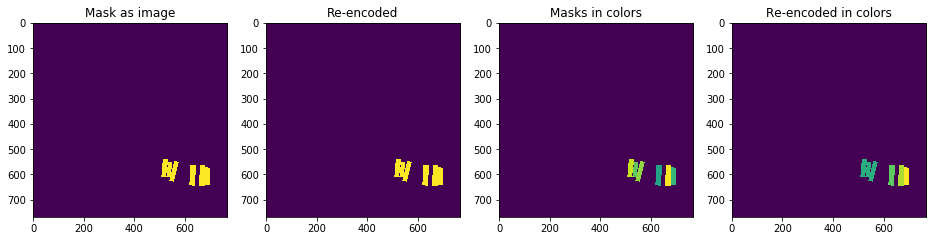

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 5))
rle_0 = masks.query('ImageId=="0b258093a.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0)
ax1.set_title('Mask as image')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1)
ax2.set_title('Re-encoded')
img_c = masks_as_color(rle_0)
ax3.imshow(img_c)
ax3.set_title('Masks in colors')
img_c = masks_as_color(rle_1)
ax4.imshow(img_c)
ax4.set_title('Re-encoded in colors')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
print(np.sum(img_0 - img_1), 'error')

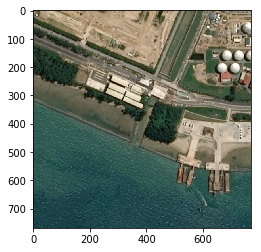

In [9]:
img = cv2.imread("../input/train_v2/0b258093a.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

ImageId  ships  has_ship has_ship_vec  file_size_kb
41728   37a4c674c.jpg      0       0.0        [0.0]    244.680664
28108   2559a1323.jpg      0       0.0        [0.0]    115.003906
186742  f85fd7931.jpg      0       0.0        [0.0]    135.510742
47913   3fed9f27e.jpg      0       0.0        [0.0]     95.709961
107480  8ee7dc033.jpg      0       0.0        [0.0]    101.838867
27442   2481f29b7.jpg      0       0.0        [0.0]    186.966797
131661  af082c1a9.jpg      2       1.0        [1.0]    131.215820

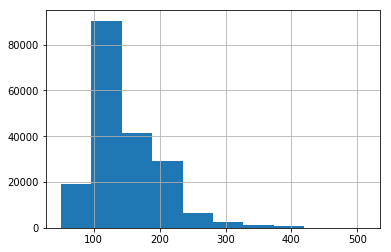

In [10]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

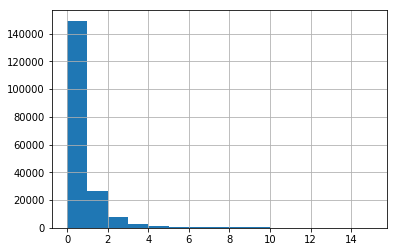

In [11]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

12788 masks


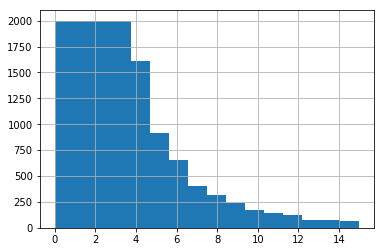

In [12]:
SAMPLES_PER_GROUP = 2000
#with_ships_df = unique_img_ids[unique_img_ids['ships'] != 0]
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=unique_img_ids['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [13]:
balanced_train_df.sample(20)

ImageId  ships  has_ship has_ship_vec  file_size_kb
ships                                                                  
12    183074  f3708f6d9.jpg     12       1.0        [1.0]    150.074219
4     170305  e27eda89e.jpg      4       1.0        [1.0]    135.334961
1     121131  a10b2631a.jpg      1       1.0        [1.0]    132.362305
3     60362   507424437.jpg      3       1.0        [1.0]    107.050781
1     52389   45c3dffcd.jpg      1       1.0        [1.0]     99.930664
3     43220   39970aaaf.jpg      3       1.0        [1.0]    108.013672
4     188567  facdebd83.jpg      4       1.0        [1.0]    229.965820
2     150260  c7d1fb1c2.jpg      2       1.0        [1.0]    229.933594
0     131782  af3497479.jpg      0       0.0        [0.0]     78.356445
      122574  a2fe803c9.jpg      0       0.0        [0.0]    180.029297
5     178289  ed1e57c6d.jpg      5       1.0        [1.0]    131.724609
3     16565   1607d9816.jpg      3       1.0        [1.0]    115.976562
5     105773  8cac2e077.jpg      5       1.0        [1.0]    164.955078
4     155672  cf0cfed50.jpg      4       1.0        [1.0]    116.374023
7     6806    0908bfa81.jpg      7       1.0        [1.0]    126.284180
3     176787  eb22eb36f.jpg      3       1.0        [1.0]     99.708984
0     62072   52ae0075c.jpg      0       0.0        [0.0]     88.846680
      102626  8877f5b22.jpg      0       0.0        [0.0]     87.580078
      69498   5c6e1b032.jpg      0       0.0        [0.0]    120.707031
3     33434   2c696bc10.jpg      3       1.0        [1.0]    196.500000

In [14]:
# %%time
# from tqdm import tqdm_notebook
# print(len(masks))
# df = pd.merge(masks, balanced_train_df)
# areas = []
# hues = []
# for img_id, encode in tqdm_notebook(zip(masks['ImageId'], masks['EncodedPixels'])):
#     if isinstance(encode, str):
#         mask = masks_as_image([encode])
#         img_path = os.path.join(train_image_dir, img_id)
#         img = cv2.imread(img_path)
#         labels = label(mask)
#         for k in np.unique(labels[labels>0]):
#             areas.append(np.sum(labels==k))
#             obj = np.expand_dims(img[np.where(labels==k)],0)
#             hsv = cv2.cvtColor(obj, cv2.COLOR_BGR2HSV)
#             hues.append(hsv[:,:,0].mean())

In [15]:
# %%time
# from tqdm import tqdm_notebook
# print(len(masks))
# df = pd.merge(masks, balanced_train_df)
# pix_num = []

# for img_id, encode in tqdm_notebook(zip(masks['ImageId'], masks['EncodedPixels'])):
#     if isinstance(encode, str):
#         mask = masks_as_image([encode])
#         pix_num.append(np.sum(mask))

In [16]:
import pickle
# with open("areas.pickle", "wb") as f:
#     pickle.dump(areas, f, protocol=pickle.HIGHEST_PROTOCOL)
# with open("hues.pickle", "wb") as f:
#     pickle.dump(hues, f, protocol=pickle.HIGHEST_PROTOCOL)
# with open("pix_num.pickle", "wb") as f:
#     pickle.dump(pix_num, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('areas.pickle', 'rb') as f:
    areas = pickle.load(f)
with open('hues.pickle', 'rb') as f:
    hues = pickle.load(f)
with open('pix_num.pickle', 'rb') as f:
    pix_num = pickle.load(f)
hues = np.array(hues)
areas = np.array(areas)
areas_sorted = np.sort(areas)
pix_num = np.array(pix_num)

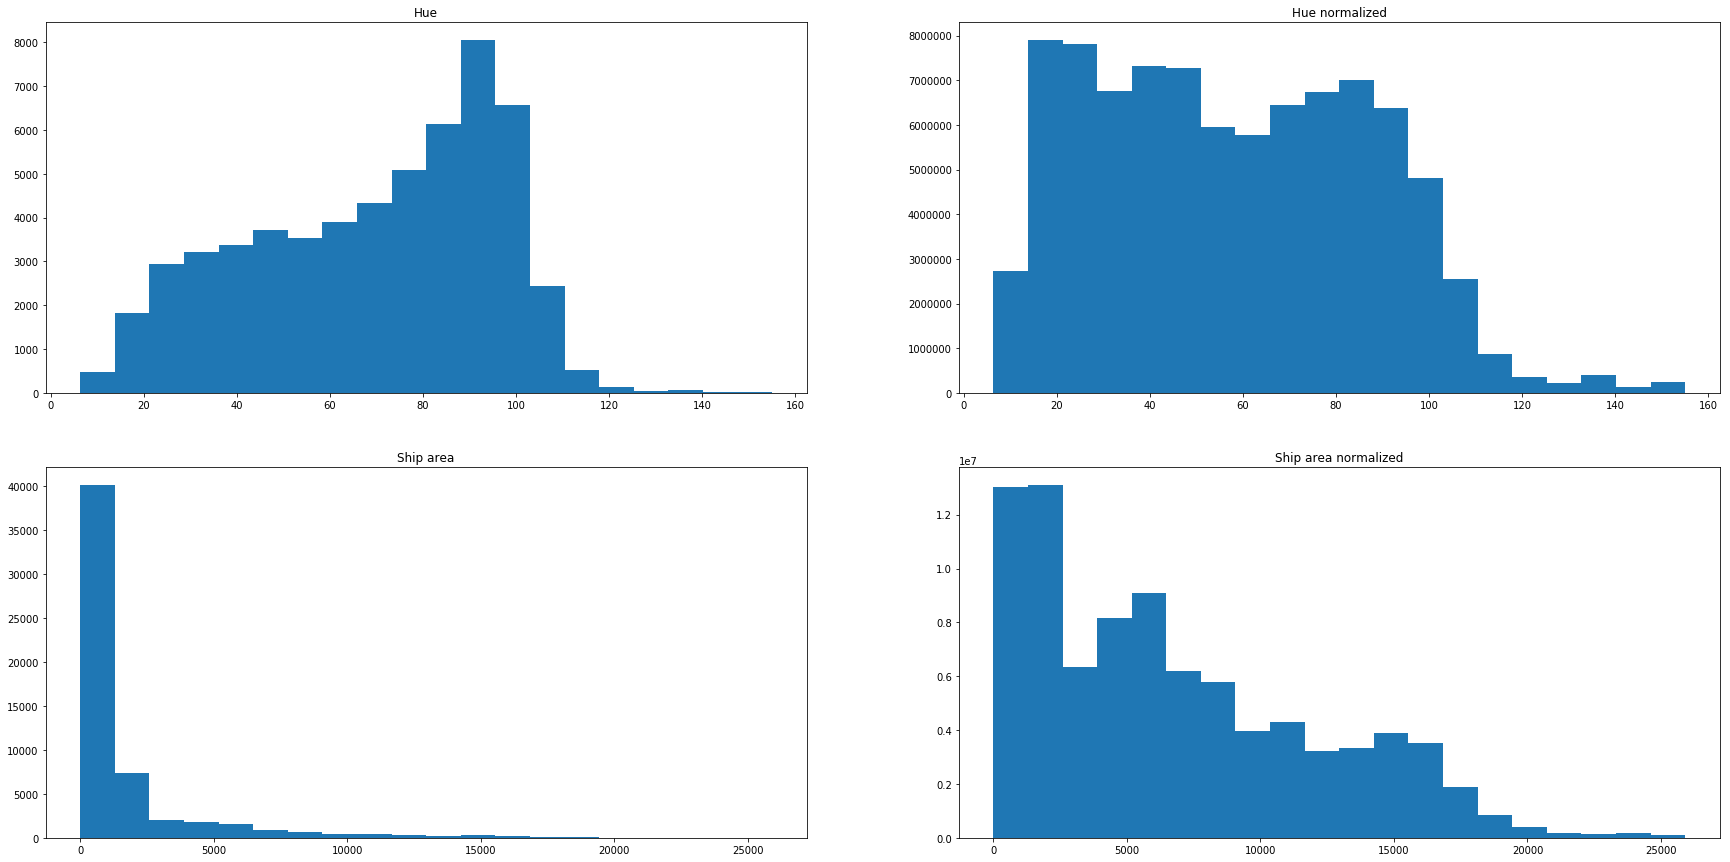

In [17]:
_, ax = plt.subplots(2, 2, figsize = (30, 15))

ax[0,0].hist(hues, bins=20)
ax[0,0].set_title('Hue')

ax[0,1].hist(hues, bins=20, weights=areas)
ax[0,1].set_title('Hue normalized')

ax[1,0].hist(areas_sorted, bins=20)
ax[1,0].set_title('Ship area')

ax[1,1].hist(areas_sorted, bins=20, weights=areas_sorted)
ax[1,1].set_title('Ship area normalized')
plt.show()

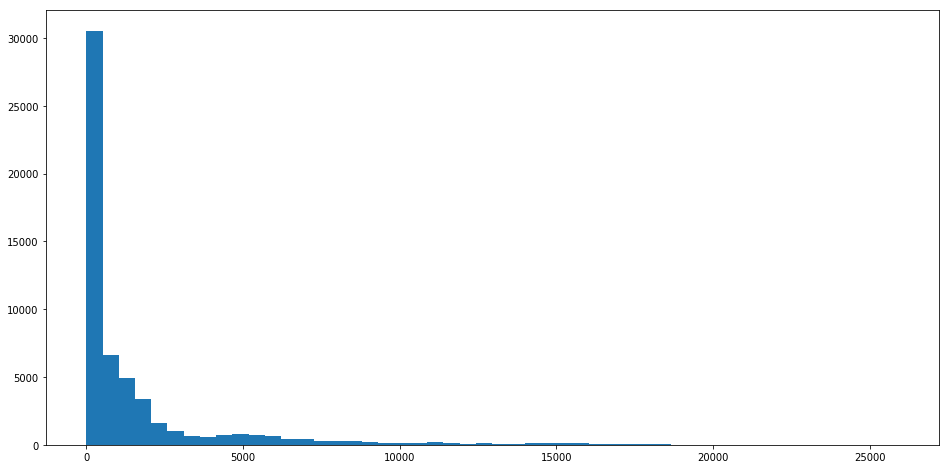

In [18]:
plt.figure(figsize=(16,8))
plt.hist(pix_num, bins=50)
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.1, 
                 stratify = balanced_train_df['ships'])
#print(len(train_df.groupby('ImageId')), train_ids.shape[0])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

39781 training masks
4421 validation masks


In [20]:
train_df.sample(5)

ImageId                                      EncodedPixels  \
38623  f7a5e610c.jpg  567574 4 568342 4 569110 4 569878 4 570646 4 5...   
25983  a677c26b0.jpg  204326 7 205094 19 205862 25 206630 25 207398 ...   
1693   0aa505b96.jpg  351568 2 352336 5 353104 7 353871 8 354639 7 3...   
29896  bfd0ccdb0.jpg  276598 14 277339 41 278081 67 278835 81 279603...   
9859   4072f0c20.jpg  547994 3 548762 5 549530 5 550298 5 551066 5 5...   

       ships  has_ship has_ship_vec  file_size_kb  
38623      5       1.0        [1.0]    143.109375  
25983      7       1.0        [1.0]    306.184570  
1693      13       1.0        [1.0]    211.548828  
29896      6       1.0        [1.0]    158.623047  
9859       5       1.0        [1.0]    117.000977

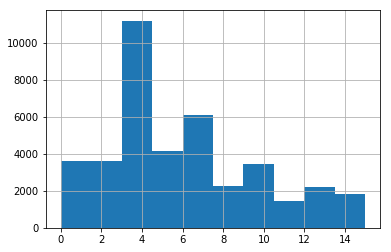

In [21]:
train_df['ships'].hist()

In [22]:
df = pd.DataFrame({'A': 'a a b'.split(), 'B': [1,2,3], 'C': [4,6, 5]})
list(df.groupby('A'))[0]

('a',    A  B  C
 0  a  1  4
 1  a  2  6)

In [23]:
len(balanced_train_df)

12788

In [24]:
gc.collect()

10806

In [25]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from functools import partial
from torch.nn import functional as F

import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import random
from IPython.core.debugger import set_trace

from imgaug import augmenters as iaa
import imgaug as ia
from PIL import Image

class SegmentationDataset(Dataset):
            
    def __init__(self, in_df, train=True, transform_input=None, transform_output=None, seed_fn=None):
        assert bool(transform_input) == bool(transform_output)
        
        self.transform_input = transform_input
        self.transform_output = transform_output
        self.seed_fn = seed_fn
                
        all_batches = list(in_df.groupby('ImageId'))
        rgb_param_list = []
        mask_param_list = []
        thresh = 0.2 if train else 1
        
        for c_img_id, c_masks in all_batches:
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
            h = c_mask.shape[0]//IMG_CROPPING[0]
            w = c_mask.shape[1]//IMG_CROPPING[1]
            #set_trace()
            for y0 in np.arange(0, c_mask.shape[0], h):
                for x0 in np.arange(0, c_mask.shape[1], w):
                    y1 = y0 + h
                    x1 = x0 + w
                    if x1 <= c_mask.shape[1] and y1 <= c_mask.shape[0]:
                        if np.sum(c_mask[y0:y1, x0:x1]) >500 or np.random.rand(1)[0] < thresh:
                            rgb_param_list += [(c_img_id, (y0, y1, x0, x1))] # to save memory
                            mask_param_list += [c_masks['EncodedPixels'].values] # to save memory
            
        self.rgb_param_list = rgb_param_list
        self.mask_param_list = mask_param_list
    
    def _set_seed(self, seed):
        random.seed(seed)
        torch.manual_seed(seed)
        if self.seed_fn:
            self.seed_fn(seed)
        
    def __getitem__(self, idx):
        in_img_param = self.rgb_param_list[idx]
        out_mask_param = self.mask_param_list[idx]
        
        in_img_path = os.path.join(train_image_dir, in_img_param[0])
        crop_params = in_img_param[1]
        in_img = imread(in_img_path)[crop_params[0]:crop_params[1], crop_params[2]:crop_params[3]]
        in_img = in_img/255.
        in_img = in_img.astype(np.float32)
        
        out_mask = np.expand_dims(masks_as_image(out_mask_param), -1)
        out_mask = out_mask[crop_params[0]:crop_params[1], crop_params[2]:crop_params[3]]
        out_mask = out_mask.astype(np.float32)
        #print(in_img.shape)
        #set_trace()
        if self.transform_input:
            seed = random.randint(0, 2**32)
            self._set_seed(seed)
            in_img = self.transform_input(in_img)
            self._set_seed(seed)
            out_mask = self.transform_output(out_mask)
          
        return in_img, out_mask
        
    def __len__(self):
        return len(self.rgb_param_list)
    

In [26]:
# geometric_augs = [
#     transforms.RandomResizedCrop(299),
#     transforms.RandomRotation(45),
# ]

# color_augs = [
#     transforms.ColorJitter(hue=0.05, saturation=0.4)
# ]

# def make_tfs(augs):
#     return transforms.Compose(augs + [transforms.ToTensor()])

geometric_augs = [
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.5), # vertically flip 50% of all images
        iaa.Affine(scale=(0.9, 1.25),
                   #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                   rotate=(-45, 45),
                   mode="reflect")
]
color_augs = [
    iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=2.0)),
    iaa.OneOf([
        iaa.GaussianBlur(sigma=(0.0, 2.0)),
        iaa.AverageBlur(k=(2, 3)),
        #iaa.MedianBlur(k=3)
    ]),
    iaa.AddToHueAndSaturation(value=(-5, 5), per_channel=True)
]

def iaug_to_pytorch(augs, rgb=True):
    if rgb:
        return transforms.Compose([
        lambda x: np.array(x),
        lambda x: iaa.Sequential(augs).augment_image(x),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    else:
        return transforms.Compose([
        lambda x: np.array(x),
        lambda x: iaa.Sequential(augs).augment_image(x),
        transforms.ToTensor()
    ])


In [27]:
%%time
train_ds = SegmentationDataset(train_df, train=True,
                          transform_input=iaug_to_pytorch(geometric_augs + color_augs, rgb=True),
                          transform_output=iaug_to_pytorch(geometric_augs, rgb=False),
                          seed_fn=lambda x: ia.seed(x % 2**32))

valid_ds = SegmentationDataset(valid_df, train=False,
                          transform_input=iaug_to_pytorch([], rgb=True),
                          transform_output=iaug_to_pytorch([], rgb=False),
                          seed_fn=lambda x: ia.seed(x % 2**32))

CPU times: user 59.6 s, sys: 38.1 ms, total: 59.6 s
Wall time: 59.7 s


In [28]:
print(len(train_ds)), print(len(valid_ds))

19209
5116


(None, None)

In [29]:
def show(img):
    npimg = img.numpy()
    plt.figure()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

In [1]:
from torchvision.utils import make_grid
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 10

imgs = [train_ds[i] for i in range(6)]

show(torchvision.utils.make_grid(torch.stack([img[0] for img in imgs])))
show(torchvision.utils.make_grid(torch.stack([img[1] for img in imgs])))

In [31]:
def show_dataset(dataset, n=6):
    img = np.vstack((np.hstack((np.asarray(np.transpose(dataset[i+6][0], (1, 2, 0))) for _ in range(n)))
                   for i in range(4)))
    print(img.shape)
    plt.imshow(img)
    plt.axis('off')

In [2]:
show_dataset(train_ds)

In [32]:
torch.cuda.device_count()

4

In [33]:
import os
# torch.cuda.empty_cache()
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
torch.cuda.empty_cache()

In [34]:
from unet_models import AlbuNet, UNet11, UNetVGG16, UNetResNet, unet11
from torch.optim import Adam

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
model = torch.nn.DataParallel(unet11(pretrained='carvana')).cuda()
model_name='Unet11_Focal_v2'
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_ds,
                          batch_size=BATCH_SIZE, 
                          #num_workers=torch.cuda.device_count(),
                          shuffle=True)

val_loader = DataLoader(dataset=valid_ds,
                        batch_size=BATCH_SIZE,
                        #num_workers=torch.cuda.device_count(),
                        shuffle=False)

from torchsummary import summary

summary(model, input_size=(3, 384, 384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 384, 384]           1,792
            Conv2d-2         [-1, 64, 384, 384]           1,792
            Conv2d-3         [-1, 64, 384, 384]           1,792
            Conv2d-4         [-1, 64, 384, 384]           1,792
              ReLU-5         [-1, 64, 384, 384]               0
              ReLU-6         [-1, 64, 384, 384]               0
              ReLU-7         [-1, 64, 384, 384]               0
              ReLU-8         [-1, 64, 384, 384]               0
         MaxPool2d-9         [-1, 64, 192, 192]               0
        MaxPool2d-10         [-1, 64, 192, 192]               0
           Conv2d-11        [-1, 128, 192, 192]          73,856
           Conv2d-12        [-1, 128, 192, 192]          73,856
           Conv2d-13        [-1, 128, 192, 192]          73,856
           Conv2d-14        [-1, 128, 1

In [42]:
def dice_loss(inputs, targets):
    inputs = torch.sigmoid(inputs)
    smooth = 1.0

    iflat = inputs.view(-1)
    tflat = targets.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        max_val = (-inputs).clamp(min=0)
        loss = inputs - inputs * targets + max_val + \
            ((-max_val).exp() + (-inputs - max_val).exp()).log()

        invprobs = F.logsigmoid(-inputs * (targets * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss

        return loss.mean()

class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, inputs, targets):
        loss = self.alpha*self.focal(inputs, targets) - torch.log(dice_loss(inputs, targets))
        return loss.mean()


class IoU(nn.Module):
    def __init__(self, thresh=0.5, sigmoid=True):
        super(IoU, self).__init__()
        self.thresh = thresh
        self.sigmoid = sigmoid
        
    def forward(self, outputs, targets):
        if self.sigmoid:
            outputs = torch.sigmoid(outputs)
        num = outputs.size(0)
        outputs = (outputs.view(num, -1) > self.thresh).float()
        targets = targets.view(num, -1)
        eps = 1e-15
        intersection = (outputs * targets).sum(1)
        union = outputs.sum(1) + targets.sum(1) - intersection
        return ((intersection + eps) / (union + eps)).mean()

    
class DiceScore(nn.Module):
    def __init__(self, thresh=0.5, smooth=1e-15, sigmoid=True):
        super(DiceScore, self).__init__()
        self.thresh = thresh
        self.smooth = smooth
        self.sigmoid = sigmoid
        
    def forward(self, outputs, targets):
        if self.sigmoid:
            outputs = torch.sigmoid(outputs)
        num = outputs.size(0)
        outputs = (outputs.view(num, -1) > self.thresh).float()
        targets = targets.view(num, -1)
        intersection = (outputs * targets).sum(1)
        scores = (2. * intersection + self.smooth) / (outputs.sum(1) + targets.sum(1) + self.smooth)
        return scores.mean()


class SoftDiceScore(nn.Module):
    def __init__(self):
        super(SoftDiceScore, self).__init__()
        
    def forward(self, outputs, targets):
        outputs = torch.sigmoid(outputs)
        num = outputs.size(0)
        outputs = outputs.view(num, -1)
        targets = targets.view(num, -1)
        intersection = (outputs * targets).sum(1)
        scores = (2. * intersection + 1.) / (outputs.sum(1) + targets.sum(1) + 1.)
        return scores.mean()
    
class Loss(nn.Module):
    def __init__(self, bce_weight=1.):
        super(Loss, self).__init__()
        self.partial_loss = nn.BCELoss()
        self.bce_weight = bce_weight

    def forward(self, outputs, targets):
        outputs = torch.sigmoid(outputs)
        num = outputs.size(0)
        eps=1e-15
        outputs = outputs.view(num, -1)
        targets = targets.view(num, -1)
        intersection = (outputs * targets).sum(1)
        union = outputs.sum(1) + targets.sum(1) - intersection
        iou_score = ((intersection + eps) / (union + eps)).mean()
        loss = self.bce_weight * self.partial_loss(outputs, targets) - torch.log(iou_score)
        return loss

In [43]:
from IPython.core.debugger import set_trace
from tqdm import tqdm_notebook as tqdm

def validate(val_loader, model):
    model.eval()
    
    with torch.no_grad():
        
        dice_score_obj = DiceScore().cuda()
        soft_dice_score_obj = SoftDiceScore().cuda()
        iou_obj = IoU().cuda()
        avg_score = 0
        avg_iou = 0
        avg_soft_dice_score = 0
        cnt = 0
        for i, (inputs, targets) in tqdm(enumerate(val_loader), total=len(val_loader),
                                        desc='Validation'):
            inputs = inputs.cuda()
            targets = targets.cuda()

            outputs = model(inputs)
    
            #set_trace()
            score = dice_score_obj(outputs, targets)
            soft_dice_score = soft_dice_score_obj(outputs, targets)
            iou_score = iou_obj(outputs, targets)
            
            avg_score += score.item()* len(inputs)
            avg_soft_dice_score += soft_dice_score.item() * len(inputs)
            avg_iou += iou_score.item()* len(inputs)
            
            cnt += len(inputs)

        avg_score /= cnt
        avg_soft_dice_score /= cnt
        avg_iou /= cnt
        print ('[VAL] dice={:.6f}  soft_dice_score={:.6f}  iou={:.6f}'.format(avg_score, avg_soft_dice_score, avg_iou))
    return avg_score

In [ ]:
import time

n_epochs = 100
start_epoch = 1

ckpt_path = os.path.join('./saved_models', 'model_{}_best.pth.tar'.format(model_name))
if os.path.isfile(ckpt_path):
    print("=> loading checkpoint '{}'".format(ckpt_path))
    checkpoint = torch.load(ckpt_path)
    best_score = checkpoint['score']
else:
    best_score = float('-inf')

for epoch in range(start_epoch, n_epochs + 1):

    optimizer = Adam(model.parameters(), lr=0.001)

    model.train()
    random.seed()

    losses = []

    criterion = MixedLoss(10.0, 2.0).cuda()
    iou_obj = IoU().cuda()
    dice_score_obj = DiceScore().cuda()
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    start = time.time()
    sum_loss = 0
    sum_iou_score = 0
    sum_dice_score = 0
    for i, (inputs, targets) in pbar:
        inputs = inputs.cuda()
        targets = targets.cuda()
        #print(i)
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        loss_val = loss.item()
        losses.append(loss_val)
        sum_loss += loss_val
        
        sum_iou_score += iou_obj(outputs, targets).item()
        sum_dice_score += dice_score_obj(outputs, targets).item()
        
        optimizer.zero_grad()
        batch_size = inputs.size(0)

        loss.backward()
        optimizer.step()
        
        pbar.set_description_str(
            '[TRAIN] epoch %d/%d avg loss: %.4f   IoU %.4f   Dice %.4f (%.2f im/s)'
            % (epoch, n_epochs,
               sum_loss / (i + 1),
               sum_iou_score / (i + 1),
               sum_dice_score / (i + 1),
               batch_size / (time.time() - start)))
        start = time.time()
        
    
    score = validate(val_loader, model)

    # store best loss and save a model checkpoint
    if score > best_score:
        ckpt_dict = {
            'state_dict': model.state_dict(),
            'score': score
        }
        print ("Model improved!!! {} -> {}".format(best_score, score))
        torch.save(ckpt_dict, os.path.join('./saved_models', 'model_{}_best.pth.tar'.format(model_name)))
        best_score = score
    else:
        print("Model didn't improve")


[VAL] dice=0.646291  soft_dice_score=0.396328  iou=0.607521
Model improved!!! -inf -> 0.6462911779848834


[VAL] dice=0.682558  soft_dice_score=0.296070  iou=0.639866
Model improved!!! 0.6462911779848834 -> 0.6825578101357974


[VAL] dice=0.737901  soft_dice_score=0.482454  iou=0.697005
Model improved!!! 0.6825578101357974 -> 0.73790099692587


[VAL] dice=0.702044  soft_dice_score=0.245606  iou=0.662852
Model didn't improve


[VAL] dice=0.720389  soft_dice_score=0.330063  iou=0.678313
Model didn't improve


[VAL] dice=0.740093  soft_dice_score=0.338402  iou=0.700010
Model improved!!! 0.73790099692587 -> 0.7400930904149077


[VAL] dice=0.713000  soft_dice_score=0.377390  iou=0.669921
Model didn't improve


[VAL] dice=0.735066  soft_dice_score=0.272025  iou=0.691933
Model didn't improve


[VAL] dice=0.769554  soft_dice_score=0.441860  iou=0.730908
Model improved!!! 0.7400930904149077 -> 0.7695537621011205


[VAL] dice=0.715861  soft_dice_score=0.442198  iou=0.676827
Model didn't improve


[VAL] dice=0.775413  soft_dice_score=0.502343  iou=0.736000
Model improved!!! 0.7695537621011205 -> 0.775412592457271


[VAL] dice=0.769616  soft_dice_score=0.416804  iou=0.730018
Model didn't improve


[VAL] dice=0.776773  soft_dice_score=0.516423  iou=0.739291
Model improved!!! 0.775412592457271 -> 0.7767727538605422


[VAL] dice=0.744804  soft_dice_score=0.329238  iou=0.707135
Model didn't improve


[VAL] dice=0.763693  soft_dice_score=0.348574  iou=0.724041
Model didn't improve


[VAL] dice=0.752571  soft_dice_score=0.385366  iou=0.713403
Model didn't improve


[VAL] dice=0.763112  soft_dice_score=0.376760  iou=0.722470
Model didn't improve


[VAL] dice=0.754633  soft_dice_score=0.427270  iou=0.715834
Model didn't improve


[VAL] dice=0.762362  soft_dice_score=0.322726  iou=0.720852
Model didn't improve


[VAL] dice=0.757494  soft_dice_score=0.481092  iou=0.719053
Model didn't improve


[VAL] dice=0.779404  soft_dice_score=0.442947  iou=0.739506
Model improved!!! 0.7767727538605422 -> 0.7794042934282763


[VAL] dice=0.778027  soft_dice_score=0.416466  iou=0.736774
Model didn't improve


[VAL] dice=0.757236  soft_dice_score=0.318857  iou=0.718128
Model didn't improve


[VAL] dice=0.745726  soft_dice_score=0.327510  iou=0.703234
Model didn't improve


[VAL] dice=0.770792  soft_dice_score=0.367975  iou=0.730461
Model didn't improve


[VAL] dice=0.790896  soft_dice_score=0.496142  iou=0.751628
Model improved!!! 0.7794042934282763 -> 0.7908962795378363


[VAL] dice=0.772421  soft_dice_score=0.376786  iou=0.735461
Model didn't improve


[VAL] dice=0.786761  soft_dice_score=0.421747  iou=0.748094
Model didn't improve


[VAL] dice=0.769798  soft_dice_score=0.342368  iou=0.729768
Model didn't improve


[VAL] dice=0.783967  soft_dice_score=0.456860  iou=0.743618
Model didn't improve


[VAL] dice=0.783234  soft_dice_score=0.426866  iou=0.743154
Model didn't improve


[VAL] dice=0.790106  soft_dice_score=0.453546  iou=0.749621
Model didn't improve


[VAL] dice=0.790989  soft_dice_score=0.454627  iou=0.752175
Model improved!!! 0.7908962795378363 -> 0.7909888528211682


In [69]:
# torch.cuda.empty_cache()
# model = nn.DataParallel(UNet11()).cuda()
# ckpt_path = os.path.join('./saved_models', 'model_{}_best.pth.tar'.format(model_name))
# checkpoint = torch.load(ckpt_path)
# model.load_state_dict(checkpoint['state_dict'])

In [71]:
checkpoint['score']

0.8105421783022093

In [45]:
next(iter(val_loader))[0].shape

torch.Size([32, 3, 384, 384])

In [3]:
model.eval()
pred_y = None
with torch.no_grad():
    
    for i, (inputs, targets) in tqdm(enumerate(val_loader), total=len(val_loader), desc='Validation'):
        inputs = inputs.cuda()
        targets = targets.cuda()

        outputs = torch.sigmoid(model(inputs)).cpu().numpy()
        pred_y = outputs if pred_y is None else np.concatenate((pred_y, outputs), axis=0)


In [47]:
pred_y.shape

(1344, 1, 384, 384)

In [48]:
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

(1344, 1, 384, 384) 0.0 1.0 0.0046062786


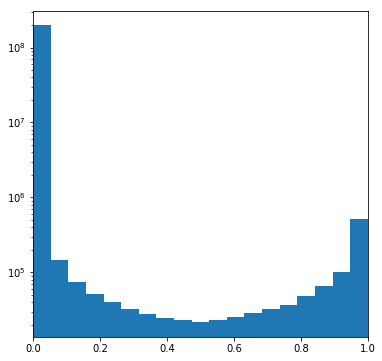

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 20))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

In [50]:
gc.collect()

5341

In [51]:
from PIL import Image
class PredictDataset(Dataset):
    
    @staticmethod
    def _load_input_image(path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
        
    def __init__(self, input_root, img_ids, ignore_ids=None, transform_input=None):  
        self.transform_input = transform_input
        self.input_root = input_root
        in_img_ids = []
        
        for c_img_id in img_ids:
            if ignore_ids and c_img_id in ignore_ids:
                continue
            in_img_ids += [c_img_id]
       
        self.in_img_ids = in_img_ids
        
    def __getitem__(self, idx):
        in_img_id = self.in_img_ids[idx]
        in_img_path = os.path.join(self.input_root, in_img_id)
        in_img = np.array(self._load_input_image(in_img_path))
        in_img = in_img.astype(np.float32)/255.
        
        in_img_crops = []
        h = in_img.shape[0]//IMG_CROPPING[0]
        w = in_img.shape[1]//IMG_CROPPING[1]
        for y0 in np.arange(0, in_img.shape[0], h):
            for x0 in np.arange(0, in_img.shape[1], w):
                y1 = y0 + h
                x1 = x0 + w
                if x1 <= in_img.shape[1] and y1 <= in_img.shape[0]:
                    in_img_crops += [in_img[y0:y1, x0:x1]]
        
        #set_trace()
        if self.transform_input:
            in_img = np.stack([self.transform_input(img) for img in in_img_crops], 0)
          
        return torch.tensor(in_img), in_img_id
        
    def __len__(self):
        return len(self.in_img_ids)
    
img_prepare = transforms.Compose([
        lambda x: np.array(x),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

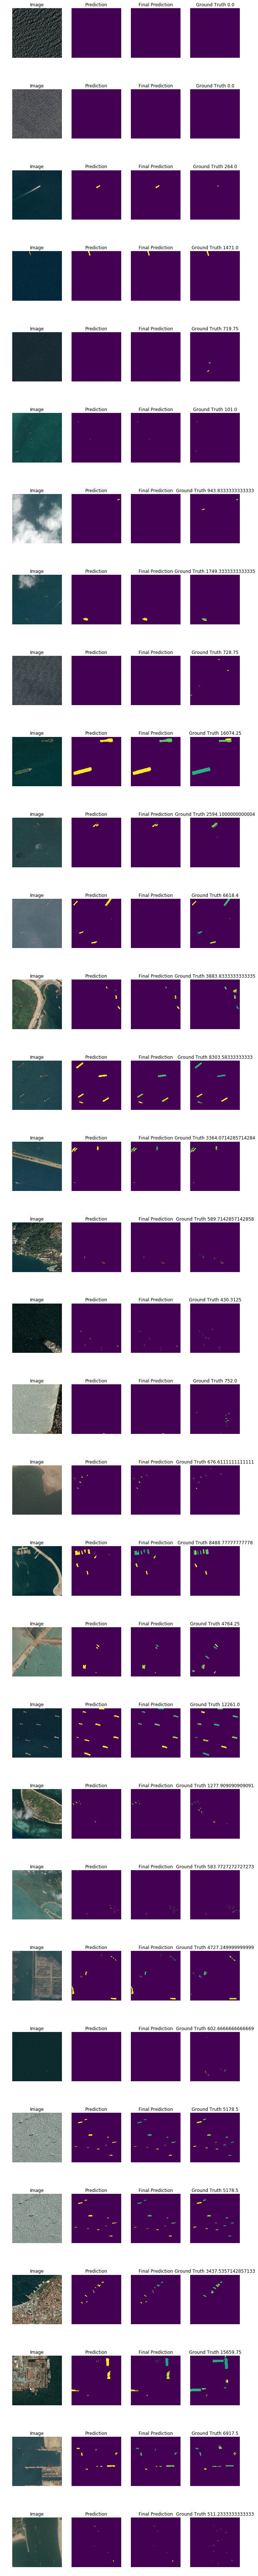

In [52]:
## Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(2))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (11, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
samples.head()

val_samples_ds = PredictDataset(input_root=train_image_dir, img_ids=samples.ImageId.values,
                                transform_input=img_prepare)

val_samples_loader = DataLoader(dataset=val_samples_ds,
                                batch_size=1,
                                #num_workers=torch.cuda.device_count(),
                                shuffle=False)

model.eval()

with torch.no_grad():
    
    for (ax1, ax2, ax3, ax4), (inputs, img_id) in zip(m_axs, val_samples_loader):
        img_id = img_id[0]
        img = imread(os.path.join(train_image_dir, img_id))
        img = img/255.0
        img = img.astype(np.float32)
        
        inputs = inputs[0].cuda()
        outputs = torch.sigmoid(model(inputs)).cpu().numpy()
#         pred_mask1 = np.concatenate(outputs[:3, 0], axis=1)
#         pred_mask2 = np.concatenate(outputs[3:6, 0], axis=1)
#         pred_mask3 = np.concatenate(outputs[6:9, 0], axis=1)  
        pred_mask1 = np.concatenate(outputs[:2, 0], axis=1)
        pred_mask2 = np.concatenate(outputs[2:4, 0], axis=1)
       
        pred_mask = np.concatenate((pred_mask1, pred_mask2), axis=0)
        pred_mask = binary_opening(pred_mask>0.5, disk(2))
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        #set_trace()
        ax1.imshow(img)
        ax1.set_title('Image')
        ax2.imshow(pred_mask)
        ax2.set_title('Prediction')
        reencoded = masks_as_color(multi_rle_encode(pred_mask, test=True, pix_threshold=1.0, ship_max_threshold=None, ship_min_threshold=None,\
                              rgb_img=img, hsv_img=hsv, hsv_thresh=190))
        ax3.imshow(reencoded)
        ax3.set_title('Final Prediction')
        ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(img_id))['EncodedPixels'])
        ax4.imshow(ground_truth)
        ax4.set_title('Ground Truth {}'.format(np.sum(ground_truth)))

fig.savefig('predictions.png')

In [53]:
test_paths = os.listdir('../input/test_v2')
print(len(test_paths), 'test images found')

15606 test images found


In [54]:
gc.collect()

8606

In [62]:
# ## Find a threshold to select single ships
# ship1_x, ship1_y = next(make_image_gen(valid_df[valid_df['ships'] == 1], VALID_IMG_COUNT))
# max_threshold  = np.mean(ship1_y)
# print('Max mean threshold:', max_threshold)

In [56]:
%%time
# TEST_IGNORE = ['13703f040.jpg',
#  '14715c06d.jpg',
#  '33e0ff2d5.jpg',
#  '4d4e09f2a.jpg',
#  '877691df8.jpg',
#  '8b909bb20.jpg',
#  'a8d99130e.jpg',
#  'ad55c3143.jpg',
#  'c8260c541.jpg',
#  'd6c7f17c7.jpg',
#  'dc3e7c901.jpg',
#  'e44dffe88.jpg',
#  'ef87bad36.jpg',
#  'f083256d8.jpg']
TEST_IGNORE = []

test_ds = PredictDataset(input_root=test_image_dir, img_ids=test_paths,
                         ignore_ids=TEST_IGNORE,
                         transform_input=img_prepare)

test_loader = DataLoader(dataset=test_ds,
                         batch_size=1,
                         #num_workers=torch.cuda.device_count(),
                         shuffle=False)
print(len(test_ds))

15606
CPU times: user 2.06 ms, sys: 402 µs, total: 2.46 ms
Wall time: 2.47 ms


In [57]:
#torch.backends.cudnn.enabled = False #cudnn caused memory leak:  https://github.com/pytorch/pytorch/issues/3665

In [58]:
gc.collect()

58

In [59]:
%%time
from tqdm import tqdm_notebook
import pickle


model.eval()
out_pred_rows = []

with torch.no_grad():
    for i, (inputs, img_id) in tqdm_notebook(enumerate(test_loader), total=len(test_loader), desc='Test'):
        img_id = img_id[0]
        img = imread(os.path.join(test_image_dir, img_id))
        img = img/255.0
        img = img.astype(np.float32)
        
        inputs = inputs[0].cuda()
        outputs = torch.sigmoid(model(inputs)).cpu().numpy()

#         pred_mask1 = np.concatenate(outputs[:3, 0], axis=1)
#         pred_mask2 = np.concatenate(outputs[3:6, 0], axis=1)
#         pred_mask3 = np.concatenate(outputs[6:9, 0], axis=1)  
        pred_mask1 = np.concatenate(outputs[:2, 0], axis=1)
        pred_mask2 = np.concatenate(outputs[2:4, 0], axis=1)
        pred_mask = np.concatenate((pred_mask1, pred_mask2), axis=0)
        pred_mask = binary_opening(pred_mask>0.5, disk(2))

        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        cur_rles = multi_rle_encode(pred_mask, test=True, pix_threshold=1.0, ship_max_threshold=None, ship_min_threshold=None,\
                              rgb_img=img, hsv_img=hsv, hsv_thresh=190)
        if len(cur_rles)>0:
            out_pred_rows += [[img_id, rle] for rle in cur_rles if len(rle) > 0]
        else:
            out_pred_rows += [[img_id, None]]


CPU times: user 54min 31s, sys: 10min 32s, total: 1h 5min 3s
Wall time: 57min 6s


In [60]:
sub = pd.DataFrame(out_pred_rows)
sub.columns = ['ImageId', 'EncodedPixels']
print(sub.head())
print(sub.shape)
sub = sub[sub.EncodedPixels.notnull()]
print(sub.shape)
sub.head()

         ImageId                                      EncodedPixels
0  50c973ac2.jpg                                               None
1  6908d991d.jpg  403289 4 404055 8 404821 11 405584 17 406351 1...
2  6908d991d.jpg  24032 1 24795 8 25562 11 26328 14 27095 16 278...
3  39fb51548.jpg                                               None
4  3265ccaad.jpg  365711 4 366477 8 367244 10 368011 12 368779 1...
(16737, 2)
(4091, 2)


ImageId                                      EncodedPixels
1   6908d991d.jpg  403289 4 404055 8 404821 11 405584 17 406351 1...
2   6908d991d.jpg  24032 1 24795 8 25562 11 26328 14 27095 16 278...
4   3265ccaad.jpg  365711 4 366477 8 367244 10 368011 12 368779 1...
8   8a56c9bdd.jpg  133926 9 134693 12 135460 14 136228 16 136995 ...
13  e6374ba49.jpg  142452 5 143219 7 143986 9 144753 10 145521 10...

In [61]:
# sub2 = pd.read_csv('submission.csv')
# sub = sub2.head(395)
# sub.shape

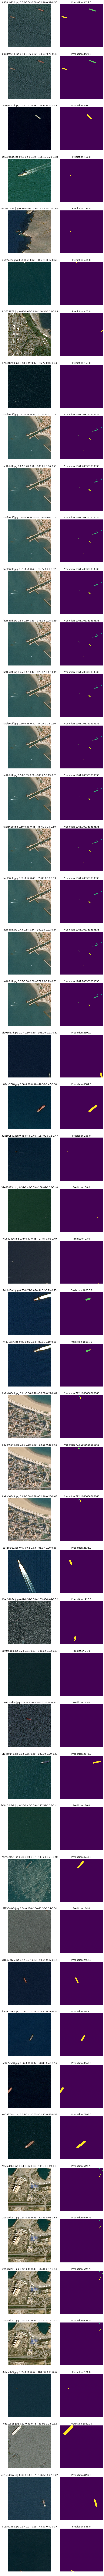

In [62]:
import numpy as np
TOP_PREDICTIONS=50
fig, m_axs = plt.subplots(TOP_PREDICTIONS, 2, figsize = (9, TOP_PREDICTIONS*5))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2), test_pred in zip(m_axs, sub[:TOP_PREDICTIONS].values):
    img_id = test_pred[0]
    c_img = imread(os.path.join(test_image_dir, img_id))
    c_img = np.expand_dims(c_img, 0)/255.0
    c_img=c_img.astype(np.float32)
    obj = np.expand_dims(c_img[0][masks_as_image([test_pred[1]]) == 1],0)
    hsv = cv2.cvtColor(obj, cv2.COLOR_RGB2HSV)
    obj=obj.reshape((-1,3))
    hsv=hsv.reshape((-1,3))
    ax1.imshow(c_img[0])
    ax1.set_title(test_pred[0] + ' %.2f-%.2f-%.2f---%.2f-%.2f-%.2f'%(obj[:,0].mean(),obj[:,1].mean(),obj[:,2].mean(),\
                                                                    hsv[:,0].mean(), hsv[:,1].mean(),hsv[:,2].mean()))
    #print(obj[:,0].mean(), obj[:,1].mean(), obj[:,2].mean())
    m = masks_as_color(sub.query('ImageId=="{}"'.format(img_id))['EncodedPixels'])
    ax2.imshow(m)
    ax2.set_title('Prediction {}'.format(np.sum(m)))

In [63]:
# submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
# submission_df.to_csv('submission.csv', index=False)
# submission_df.sample(3)

In [64]:
# submission_df['counts'] = submission_df.apply(lambda c_row: c_row['counts'] if 
#                                     isinstance(c_row['EncodedPixels'], str) else
#                                     0, 1)
# submission_df['counts'].hist()

In [66]:
sub1 = pd.read_csv('../input/sample_submission_v2.csv')
sub1 = pd.DataFrame(np.setdiff1d(sub1['ImageId'].unique(), sub['ImageId'].unique(), assume_unique=True), columns=['ImageId'])
sub1['EncodedPixels'] = None
print(len(sub1), len(sub))

sub = pd.concat([sub, sub1])
print(len(sub))
sub.to_csv('submission.csv', index=False)
sub.head()

13164 4091
17255


ImageId                                      EncodedPixels
1   6908d991d.jpg  403289 4 404055 8 404821 11 405584 17 406351 1...
2   6908d991d.jpg  24032 1 24795 8 25562 11 26328 14 27095 16 278...
4   3265ccaad.jpg  365711 4 366477 8 367244 10 368011 12 368779 1...
8   8a56c9bdd.jpg  133926 9 134693 12 135460 14 136228 16 136995 ...
13  e6374ba49.jpg  142452 5 143219 7 143986 9 144753 10 145521 10...